Date: 9 August 2025<br>
# The-Cost-of-Democracy<br>



Stas Litvak<br>
CRN#: 40397<br>
Date: 9 August 2025<br>
# Graphics Cards Price Comparison
What are the prices of some of the most popular graphics cards?

In [ ]:
!pip install google-search-results
!pip install fredapi

Searching for relevant GPU data using SerpAPI...


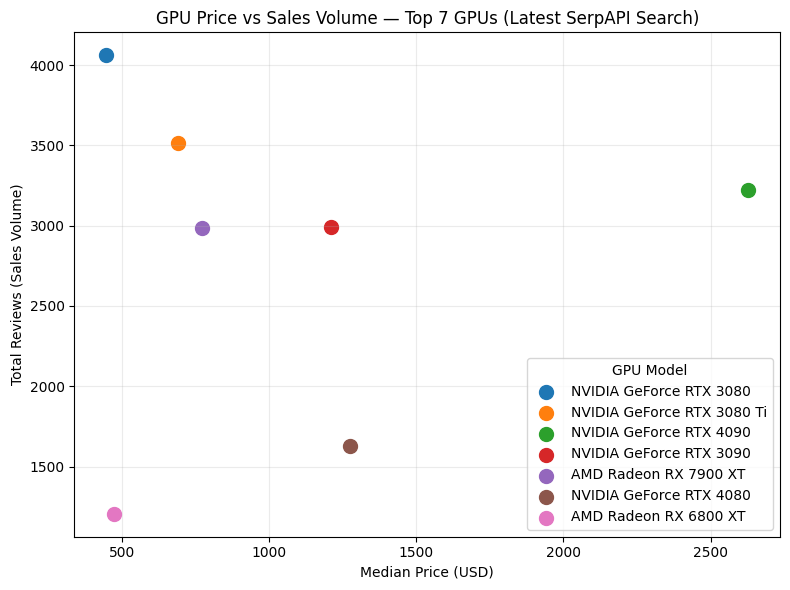

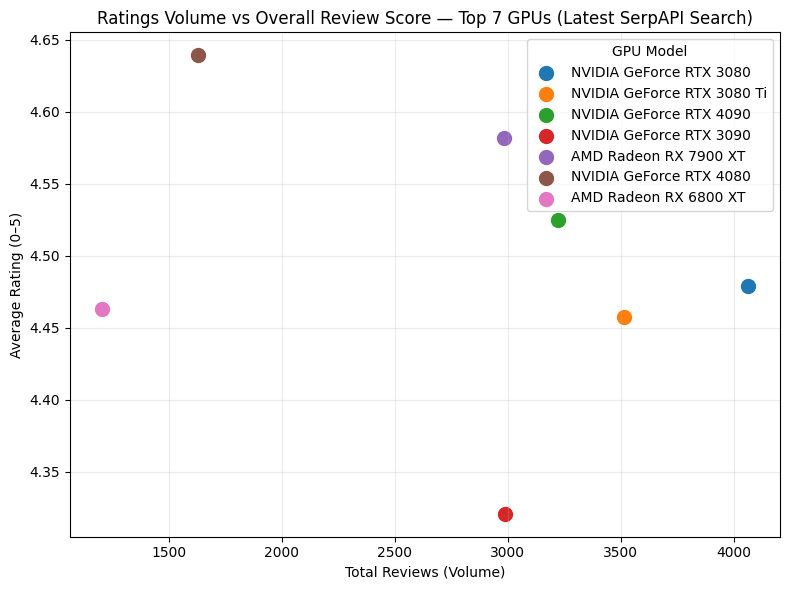

Fetching FRED series WPU5841 since 2020-01-01...


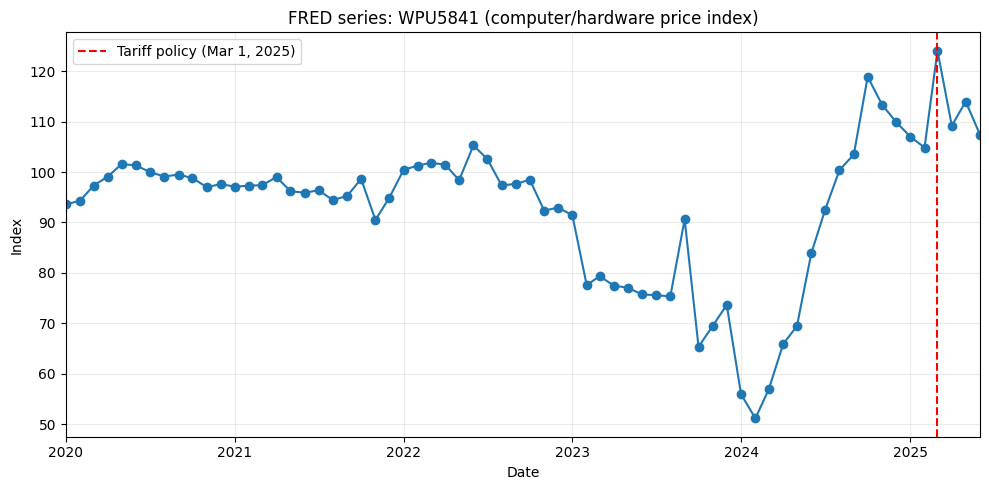

In [3]:
# Author: Stas Litvak
import os
import time
import datetime as dt
import math
import pandas as pd
import matplotlib.pyplot as plt
from serpapi import GoogleSearch
from fredapi import Fred
import requests

# CONFIG
SERPAPI_API_KEY = "b484735aff7d4281635c4e98dabddeb9e8fff811b87264da95c846d48386e966"
FRED_API_KEY = "e3a98eb469aa0274d69879357df6d096"

# GPUs to track
GPU_MODELS = [
    "NVIDIA GeForce RTX 3080",
    "NVIDIA GeForce RTX 3080 Ti",
    "NVIDIA GeForce RTX 3090",
    "NVIDIA GeForce RTX 4080",
    "NVIDIA GeForce RTX 4090",
    "AMD Radeon RX 6800 XT",
    "AMD Radeon RX 7900 XT",
]

# FRED series to use as macro price index for "computers/hardware"
# Uses 'WPU5841' (Producer Price Index by Commodity: Computer Hardware, Software, and Supplies Retailing)
FRED_SERIES_ID = "WPU5841"

# Tariff policy event date to mark on charts
TARIFF_DATE = dt.datetime(2025, 3, 1)  # March 1, 2025

# Set arbitrary date for COVID start (for plots)
COVID_START = dt.datetime(2020, 1, 1)

# Helper: SerpAPI shopping search for a specific GPU model
# Returns a list of product dicts with price, old_price, rating, reviews, source
def serpapi_get_shopping_for_model(model_name, serpapi_key):
    params = {
        "engine": "google_shopping",
        "q": model_name,
        "hl": "en",
        "gl": "us",
        "api_key": serpapi_key,
    }
    search = GoogleSearch(params)
    result = search.get_dict()

    shopping_results = result.get("shopping_results", [])
    if not isinstance(shopping_results, list):
        shopping_results = []

    parsed = []
    for item in shopping_results:
        # SerpAPI sometimes returns extracted_price, sometimes price string
        def parse_price(p):
            if not p:
                return None
            s = str(p).replace("$", "").replace(",", "").strip()
            try:
                return float(s)
            except:
                import re
                m = re.search(r"(\d[\d,]*\.?\d*)", s)
                return float(m.group(1).replace(",", "")) if m else None

        price = parse_price(item.get("extracted_price") or item.get("price"))
        old_price = parse_price(item.get("extracted_old_price") or item.get("old_price"))

        rating = item.get("rating")
        reviews = item.get("reviews")
        try:
            rating = float(rating) if rating is not None else None
        except:
            rating = None
        try:
            reviews = int(str(reviews).replace(",", "")) if reviews is not None else None
        except:
            reviews = None

        parsed.append({
            "title": item.get("title"),
            "source": item.get("source"),
            "price": price,
            "old_price": old_price,
            "rating": rating,
            "reviews": reviews,
            "retrieved_at": dt.datetime.utcnow()
        })
    return parsed

# -------------------------
# Step 1: Query SerpAPI for each GPU, build 2 dataframes
# -------------------------
def snapshot_gpu_prices(gpu_models, serpapi_key):
    rows = []
    for model in gpu_models:
        try:
            results = serpapi_get_shopping_for_model(model, serpapi_key)
        except Exception as e:
            print(f"SerpAPI error for {model}: {e}")
            results = []
        # compute simple aggregates: median price across listings, weighted rating
        prices = [r["price"] for r in results if r["price"] is not None]
        avg_price = float(pd.Series(prices).median()) if prices else None
        # weighted rating across found listings
        num = sum([ (r["rating"] or 0) * (r["reviews"] or 0) for r in results if r.get("rating") is not None and r.get("reviews") is not None ])
        den = sum([ r["reviews"] for r in results if r.get("reviews") is not None ])
        weighted_rating = (num / den) if den else None
        tot_reviews = den if den else 0
        rows.append({
            "model": model,
            "snapshot_date": dt.datetime.utcnow(),
            "median_price": avg_price,
            "listings_count": len(results),
            "weighted_rating": weighted_rating,
            "total_reviews": tot_reviews
        })
        # be polite: short pause
        time.sleep(1.0)
    return pd.DataFrame(rows)

# -------------------------
# Step 2: Pull FRED series (monthly)
# -------------------------
def fetch_fred_series(fred_key, series_id, start_date):
    fred = Fred(api_key=fred_key)
    ser = fred.get_series(series_id, observation_start=start_date.strftime("%Y-%m-%d"))
    df = pd.DataFrame({"date": ser.index, "index": ser.values})
    df["date"] = pd.to_datetime(df["date"])
    return df


# Plotting: GPU price trends, macro FRED series
def plot_from_serpapi(raw_results_df):
    # Aggregate to one entry per GPU model
    agg_df = (
        raw_results_df.groupby("model", as_index=False)
        .agg({
            "price": "median",     # Median price to avoid extreme outliers
            "reviews": "sum",      # Total reviews (sales volume proxy)
            "rating": "mean"       # Average rating
        })
    )

    # Pick top 7 GPUs by total reviews
    top_df = agg_df.sort_values("reviews", ascending=False).head(7).reset_index(drop=True)

    # Distinct colors for exactly 7 GPUs. Picks first 7 colors from tab10 list to
    # ensure distinctness
    colors = plt.cm.tab10.colors[:7]

    # --- 1) Price vs Sales Volume ---
    plt.figure(figsize=(8, 6))
    for i, row in top_df.iterrows():
        plt.scatter(row["price"], row["reviews"], color=colors[i], s=100, label=row["model"])

    plt.xlabel("Median Price (USD)")
    plt.ylabel("Total Reviews (Sales Volume)")
    plt.title("GPU Price vs Sales Volume — Top 7 GPUs (Latest SerpAPI Search)")

    # "loc" param allows for legend placement to be fluid
    plt.legend(title="GPU Model", loc="best")

    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

    # --- 2) Ratings Volume vs Overall Review Score ---
    plt.figure(figsize=(8, 6))
    for i, row in top_df.iterrows():
        plt.scatter(row["reviews"], row["rating"], color=colors[i], s=100, label=row["model"])

    plt.xlabel("Total Reviews (Volume)")
    plt.ylabel("Average Rating (0–5)")
    plt.title("Ratings Volume vs Overall Review Score — Top 7 GPUs (Latest SerpAPI Search)")
    plt.legend(title="GPU Model", loc="best")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()


# -------------------------
# Main Function
# -------------------------
def main():
    if not SERPAPI_API_KEY:
        raise SystemExit("Set SERPAPI_API_KEY environment variable or edit the script.")
    if not FRED_API_KEY:
        raise SystemExit("Set FRED_API_KEY environment variable or edit the script.")

    print("Searching for relevant GPU data using SerpAPI...")

    all_rows = []
    for model in GPU_MODELS:
        try:
            listings = serpapi_get_shopping_for_model(model, SERPAPI_API_KEY)
        except Exception as e:
            print(f"SerpAPI error for {model}: {e}")
            listings = []
        for item in listings:
            all_rows.append({
                "model": model,
                "price": item["price"],
                "reviews": item["reviews"],
                "rating": item["rating"]
            })
        time.sleep(1.0)

    raw_results_df = pd.DataFrame(all_rows)

    plot_from_serpapi(raw_results_df)

    # Fetch and plot FRED index
    print(f"Fetching FRED series {FRED_SERIES_ID} since 2020-01-01...")
    fred_df = fetch_fred_series(FRED_API_KEY, FRED_SERIES_ID, COVID_START)
    plt.figure(figsize=(10, 5))
    plt.plot(fred_df["date"], fred_df["index"], marker="o")
    plt.axvline(TARIFF_DATE, linestyle="--", linewidth=1.5, color="red",
                label="Tariff policy (Mar 1, 2025)")
    plt.xlim(COVID_START, fred_df["date"].max())
    plt.xlabel("Date")
    plt.ylabel("Index")
    plt.title(f"FRED series: {FRED_SERIES_ID} (computer/hardware price index)")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Nora Temkin<br>
CRN#: 40397<br>
Date: 9 August 2025<br>
### Question 1: How did smartphone prices change in the 2 months bracketing the election and the inauguration in the past 2 presidential election cycles?
-  Data sources: the Bureau of Labor Statistics' Consumer Price Index for series 'Smartphones', and Samsung's archived price data for Jan. 2020

In [ ]:
# Group Data Project Question 2 - Author: Nora Temkin
import urllib.request, urllib.parse, urllib.error, json
import re
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches
import pdb

# Data Project Question 1: how did smartphone prices change in the 2 months bracketing
## the election and the inauguration in the past 2 presidential election cycles?
### Data sources: the Bureau of Labor Statistics' Consumer Price Index for series 'Smartphones',
#### and Samsung's archived price data for Jan. 2020

# Data Project Question 2: how did laptop & tablet prices change in the 2 months bracketing
## the election and the inauguration in the past 2 presidential election cycles?
### Data sources: the Bureau of Labor Statistics' Consumer Price Index for
#### series 'Laptops, Tablets, & Portable Computers' and archived price data
##### for all available laptops on gadgetsc.com for Jan. 2020 (from Scribd)

# Data Project Question 3: do price changes in laptops seem to correlate more
### closely with price changes in microprocessors over the same time period, 
#### or with election results?
##### Data Sources: BLS Producer Price Index for Series 'Integrated Circuit
###### Packages, Including Microprocessors' and archived price data for CPUs from
####### AMT_CPU Product Price List (Scribd), w/prices converted to USD from MYR

def get_df_from_csv(filename):
    try:
        data_df = pd.read_csv(filename)
        return data_df
    except IOError:
        print("Error opening csv file. Could not create DataFrame.")
        return None

# def merge_csvs_single_cat(file_list, col_list):     # after init. testing, pass in [col_list]
#     target_hts8 = 85423100  # HTS-8 code for Electronic Circuits: Processors & Controllers in Tariff DBs
#     data_dict = {}
#     for file in file_list:
#         temp_df = pd.read_csv(file)
#         # print(temp_df.dtypes)
#         filtered_hts8_df = temp_df.loc[temp_df['hts8'] == target_hts8, col_list]
#         print(filtered_hts8_df.head(3))
#         # data_dict['']

def find_ppi_base_price(price_df, ppi_df, ppi_datestr):
    # coefficient = 100 / ppi_df.loc[ppi_df['observation_date'] == ppi_datestr, 'WPU117839']
    # avg_base_price = round(coefficient * price_df['Bundle_Price'].mean(), 2)
    avg_base_price = round(price_df['Bundle_Price'].mean(), 2)
    return avg_base_price

def find_cpi_base_price(price_df, cpi_df, cpi_month, yr_offset):
    bkwds_coefficient = 100 / cpi_df.loc[cpi_df.index[0 + yr_offset], cpi_month]
    if 'PRICE' in price_df:
        price_df.rename(columns={'PRICE': 'MSRP'}, inplace=True)
    avg_base_price = round(bkwds_coefficient * price_df['MSRP'].mean(), 2)
    return avg_base_price

def build_ppi_compare_list(ppi_df, base_price, base_yr, yr_month_tuplist, base_datestr):
    date_dict = {'Oct': '10/1', 'Nov': '11/1', 'Jan': '1/1', 'Feb': '2/1'}
    # pdb.set_trace()
    coefficient = 100 / ppi_df.loc[ppi_df['observation_date'] == base_datestr, 'WPU117839']
    price_compare_tuplist = []
    i = 0
    for time in yr_month_tuplist:
        year = time[0]
        date_txt = date_dict[time[1]]
        month = [time[1]]
        full_date_str = f"{date_txt}/{str(year)}"
        ppi_series = ppi_df.loc[ppi_df['observation_date'] == full_date_str]['WPU117839']
        ppi_series.index = [i]
        ppi_to_adj = ppi_series[i]
        adjusted_ppi = round(coefficient * ppi_to_adj, 2)
        price_series = round(base_price * (adjusted_ppi / 100), 2)
        price_series.index = [i]
        price = price_series[i]
        date_str = month[0] + '\n' + str(year)
        price_compare_tuplist.append((date_str, price))
    return price_compare_tuplist

def build_cpi_compare_list(cpi_df, base_price, base_yr, yr_month_tuplist):
    price_compare_tuplist = []
    for time in yr_month_tuplist:
        year = time[0]
        month = time[1]
        price = round(base_price * (cpi_df.loc[cpi_df.index[year - base_yr], month] / 100), 2)
        price_compare_tuplist.append((month + '\n' + str(year), price))
    return price_compare_tuplist

def merge_price_tuplists(list_of_tls):
    # list_of_tls = [tl1[(m,p), (m,p), (m,p), (m,p)], tl2[(m,p)] (m,p), (m,p), (m,p)], ...]
    merged_ptl = [] # Holds tuples w/ months + price from ea. tuplist in list_of_tls for each month
    tuple_builder = []
    tl_count = len(list_of_tls) # How many price lists (lists of tuples) are there?
    tl_length = len(list_of_tls[0]) # How many tuples are in a price list?
    prev_length = tl_length
    for tuplist in list_of_tls:
        if len(tuplist) != prev_length:
            print("Error: cannot merge tuple lists of different lengths.")
            return None
        else:
            prev_length = len(tuplist)
    for tup_num in range(tl_length):
        tuple_builder.append(list_of_tls[0][tup_num][0])    # Add month from current tuple in 1st tuplist
        for list_num in range(tl_count):    # Add price from current tuple in each tuplist
            tuple_builder.append(list_of_tls[list_num][tup_num][1])
        merged_ptl.append(tuple(tuple_builder)) # Turn tuple_builder list into tuple & append to merged_ptl
        tuple_builder.clear()
    return merged_ptl

def phone_price_compare_bargraph(prices_tuplist):
    fig, ax = plt.subplots()
    plt.title('Avg. Samsung Smartphone Prices\naround election and inauguration months')
    fig.set_facecolor('lightyellow')
    for month in prices_tuplist:
        ax.bar(month[0], month[1], color='darkviolet')
    price_patch = mplpatches.Patch(color='darkviolet', label='Average Price')
    ax.legend(handles=[price_patch], loc='upper right')
    ax.set_xlabel('Month & Year')
    ax.set_ylabel('Smartphone Price ($)')
    ax.grid()
    plt.show()
    print()
    fig.savefig('Election_Smartphone_Prices_Bar.jpg')

def laptop_price_compare_bargraph(prices_tuplist):
    fig, ax = plt.subplots()
    plt.title('Avg. Laptop Prices\naround election and inauguration months')
    fig.set_facecolor('honeydew')
    for month in prices_tuplist:
        ax.bar(month[0], month[1], color='indianred')
    price_patch = mplpatches.Patch(color='indianred', label='Average Price')
    ax.legend(handles=[price_patch], loc='upper right')
    ax.set_xlabel('Month & Year')
    ax.set_ylabel('Laptop Price ($)')
    ax.grid()
    plt.show()
    print()
    fig.savefig('Election_Laptop_Prices_Bar.jpg')

def cpu_price_bargraph(prices_tuplist):
    fig, ax = plt.subplots()
    plt.title('Avg. Processor Prices\naround election and inauguration months')
    fig.set_facecolor('azure')
    for month in prices_tuplist:
        ax.bar(month[0], month[1], color='darkorange')
    price_patch = mplpatches.Patch(color='darkorange', label='Average Price')
    ax.legend(handles=[price_patch], loc='upper right')
    ax.set_xlabel('Month & Year')
    ax.set_ylabel('Processor Price ($)')
    fig.savefig('Election_Processor_Prices_Bar.jpg')

def three_prod_price_linegraph(all_items_price_tuplist):  
    fig, ax = plt.subplots()
    plt.title('Avg. Laptop Price\naround election and inauguration months')
    fig.set_facecolor('lightyellow')
    x_list = [month[0] for month in all_items_price_tuplist]
    sp_y_list = [month[1] for month in all_items_price_tuplist]
    lt_y_list = [month[2] for month in all_items_price_tuplist]
    cpu_y_list = [month[3] for month in all_items_price_tuplist]
    ax.plot(x_list, sp_y_list, 'o-', linewidth=2.0, color='blue')
    ax.plot(x_list, lt_y_list, linestyle='-', marker='o', color='green')
    ax.plot(x_list, cpu_y_list, linestyle='-', marker='o', color='red')
    sm_patch = mplpatches.Patch(color='blue', label='Smartphone Price')
    lt_patch = mplpatches.Patch(color='green', label='Laptop Price')
    cpu_patch = mplpatches.Patch(color='red', label='Processor Price')
    ax.legend(handles=[sm_patch, lt_patch, cpu_patch], loc='upper right')
    # ax.legend(handles=[price_patch], loc='upper right')
    ax.set_xlabel('Month & Year')
    ax.set_ylabel('Avg. Price ($)')
    ax.grid()
    plt.show()
    print()
    fig.savefig('Election_Electronics_Prices_Line.jpg')

# Main execution area
target_months = [(2020, 'Oct'), (2020, 'Nov'), (2021, 'Jan'), (2021, 'Feb'), \
                 (2024, 'Oct'), (2024, 'Nov'), (2025, 'Jan'), (2025, 'Feb')]
# Question 1:
print('How did smartphone prices change in the 2 months bracketing the ' \
      + 'election\nand the inauguration in the past 2 presidential ' \
      + 'election cycles?\n')
cpi_sp_filename = '/content/drive/MyDrive/Colab Notebooks/SeriesReport-SmartPhone-CPI-2019-2025-Data-Only.csv'
sp_pricelist_filename = '/content/drive/MyDrive/Colab Notebooks/SeriesReport-SmartPhone-CPI-2019-2025_Jan2020Prices.csv'
# cpi_smartphones_df = get_df_from_csv(cpi_sp_filename)
# smsg_prices_2020_df = get_df_from_csv(sp_pricelist_filename)
cpi_smartphones_df = get_df_from_csv('SeriesReport-SmartPhone-CPI-2019-2025-Data-Only.csv')
smsg_prices_2020_df = get_df_from_csv('SeriesReport-SmartPhone-CPI-2019-2025_Jan2020Prices.csv')
smsg_prices_2020_df['UPC'] = round(smsg_prices_2020_df['UPC'], 0).astype(str)
sp_base_price = find_cpi_base_price(smsg_prices_2020_df, cpi_smartphones_df, 'Jan', 1)
sp_pricelist_by_month = build_cpi_compare_list(cpi_smartphones_df, sp_base_price, 2019, target_months)
phone_price_compare_bargraph(sp_pricelist_by_month)
print()

# Question 2:
print('How did laptop prices change in the 2 months bracketing the election\n' \
      + 'and the inauguration in the past 2 presidential election cycles?\n')
cpi_lt_filename = '/content/drive/MyDrive/Colab Notebooks/SeriesReport-LaptopsTabletsPortableComputers-BaseIsFeb2023.csv'
lt_pricelist_filename = '/content/drive/MyDrive/Colab Notebooks/476124375-Laptop-Pricelist-Jan-2020.csv'
# cpi_laptops_df = get_df_from_csv(cpi_lt_filename)
# laptop_prices_2020_df = get_df_from_csv(lt_pricelist_filename)
cpi_laptops_df = get_df_from_csv('SeriesReport-LaptopsTabletsPortableComputers-BaseIsFeb2023.csv')
laptop_prices_2020_df = get_df_from_csv('476124375-Laptop-Pricelist-Jan-2020.csv')
lt_avg_base_price = find_cpi_base_price(laptop_prices_2020_df, cpi_laptops_df, 'Jan', 1)
lt_pricelist_by_month = build_cpi_compare_list(cpi_laptops_df, lt_avg_base_price, 2019, target_months)
laptop_price_compare_bargraph(lt_pricelist_by_month)
print()

# Question 3:
print('How did smartphone and laptop price shifts correlate with changes\nin  ' \
      + 'microprocessor / CPU prices in the 2 months bracketing the election ' \
      + 'and\ninauguration in the past 2 presidential election cycles?\n')
print('\nChanges in CPU & Microprocessor Prices over this time frame:')
ppi_circuits_filename = '/content/drive/MyDrive/Colab Notebooks/FRED_PPI_Circuits and Microprocessors_2019 to 2020.csv'
cpu_pricelist_filename = '/content/drive/MyDrive/Colab Notebooks/471446431-AMT-CPU-Product-Price-List-Jan-2020.csv'
# ppi_circuits_df = get_df_from_csv(ppi_circuits_filename)
# cpu_prices_df = get_df_from_csv(cpu_pricelist_filename)
ppi_circuits_df = get_df_from_csv('FRED_PPI_Circuits and Microprocessors_2019 to 2020.csv')
cpu_prices_df = get_df_from_csv('471446431-AMT-CPU-Product-Price-List-Jan-2020.csv')
base_price_datestr = '1/1/2019'
cpu_avg_base_price = find_ppi_base_price(cpu_prices_df, ppi_circuits_df, base_price_datestr)
cpu_pricelist_by_month = build_ppi_compare_list(ppi_circuits_df, 
                                                cpu_avg_base_price, 2019, 
                                                target_months, 
                                                base_price_datestr)
cpu_price_bargraph(cpu_pricelist_by_month)
print()
all_cats_pricelists = [sp_pricelist_by_month, lt_pricelist_by_month, cpu_pricelist_by_month]
all_items_prices = merge_price_tuplists(all_cats_pricelists)
print()
three_prod_price_linegraph(all_items_prices)

How did smartphone prices change in the 2 months bracketing the election
and the inauguration in the past 2 presidential election cycles?


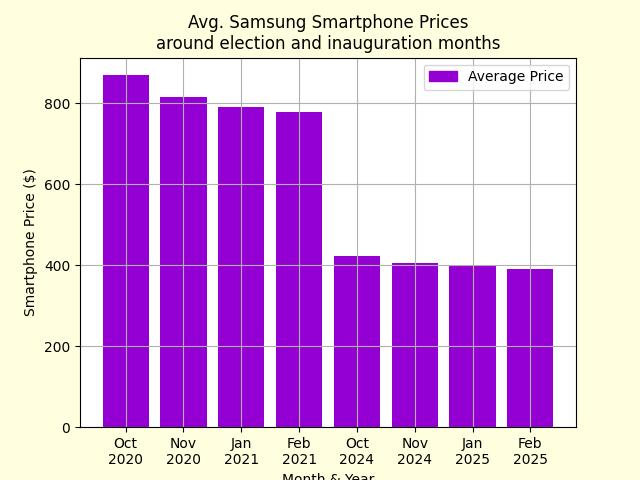

In [ ]:
from IPython.display import Image, display

# Display the image in Python
image_path = "../The-Cost-of-Democracy/Nora_Images/Election_Smartphone_Prices_Bar.jpg"
display(Image(filename=image_path))

How did laptop prices change in the 2 months bracketing the election
and the inauguration in the past 2 presidential election cycles?

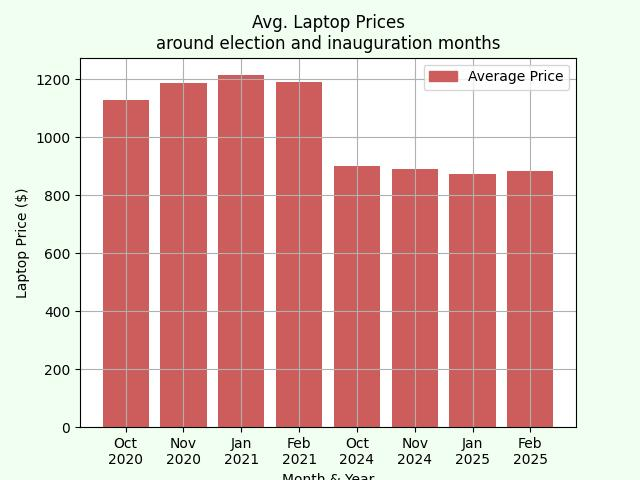

In [ ]:
from IPython.display import Image, display

# Display the image in Python
image_path = "../The-Cost-of-Democracy/Nora_Images/Election_Laptop_Prices_Bar.jpg"
display(Image(filename=image_path))



How did smartphone and laptop price shifts correlate with changes
in  microprocessor / CPU prices in the 2 months bracketing the election and
inauguration in the past 2 presidential election cycles?


Changes in CPU & Microprocessor Prices over this time frame:



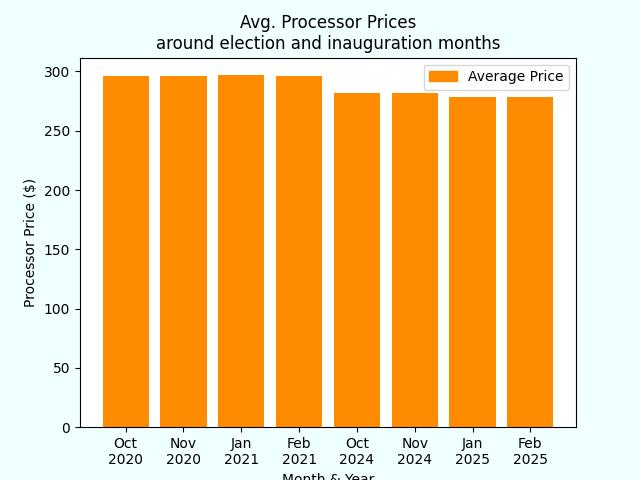

In [ ]:
from IPython.display import Image, display

# Display the image in Python
image_path = "../The-Cost-of-Democracy/Nora_Images/Election_Processor_Prices_Bar.jpg"
display(Image(filename=image_path))

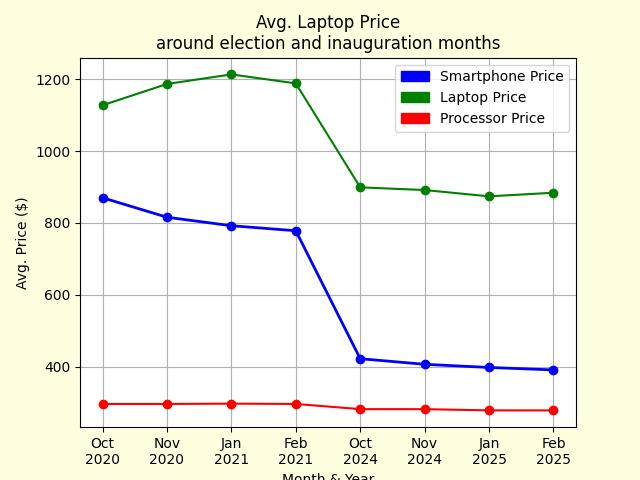

In [ ]:
# Display the image in Python
image_path = "../The-Cost-of-Democracy/Nora_Images/Election_Electronics_Prices_Line.jpg"
display(Image(filename=image_path))

Asmaa Abdul-Amin<br>
CRN#: 40397<br>
Date: 9 August 2025<br>
### 1. How has the last election cycle affected the cost of average grocery store items?

Fetch historical prices for Ground Beef, Sugar, and Eye Drops using SerpAPI and fallback web results:
- Computes changes from 2024 to the current year.
- Saves results to CSV and plots for visualization.


In [ ]:
%pip install serpapi
%pip install google-search-results
%pip install python-dotenv

In [ ]:

"""
Asmaa Abdul-Amin
CRN#: 40397
25 July 2025

SerpApi-based price estimation with Google Shopping → Web fallback,
per-item bounds, and median aggregation.

Fetches prices for Sugar, Ground Beef, and Eye Drops from 2016, 2024, and current year.
Calculates price changes, saves results to CSV, and generates plots.
"""

import os
import re
import time
from datetime import datetime
from statistics import median
from typing import List, Dict, Optional
from functools import lru_cache

import pandas as pd
import matplotlib.pyplot as plt
from serpapi import GoogleSearch
from dotenv import load_dotenv

# -------------------- ENV & PATHS --------------------
"""load_dotenv()
API_KEY = os.getenv("SERPAPI_KEY") or os.getenv("API_KEY")
if not API_KEY:
    raise ValueError("Missing SERPAPI_KEY (or API_KEY) in environment / .env")
"""
API_KEY = "f700d24395ddf3e594c0e5742f39b1cab5696ddfcc330ed3eb1ddde2c7dc8721"

try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # __file__ is not defined (e.g., running in interactive mode or notebook)
    BASE_DIR = os.getcwd()

PLOTS_DIR = os.path.join(BASE_DIR, "plots/")
DATA_DIR = os.path.join(BASE_DIR, "data/")
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

THROTTLE = 1.0  # seconds between SerpApi calls

# -------------------- ITEMS & SITES --------------------
high_yield_sites = ["walmart.com", "target.com", "amazon.com", "instacart.com"]
ITEMS_SITES: List[tuple] = [
    ("Sugar", "Domino Granulated Sugar 1Lbs", high_yield_sites),
    ("Ground_Beef", "80'%' Lean/ 20'%' Fat Ground Beef Chuck Tray", high_yield_sites),
    ("Eye_Drops", "Pataday Once Daily Relief Extra Strength Eye Drops", high_yield_sites),
]
ITEM_RULES: Dict[str, Dict] = {
    "Sugar":   {"min": 5.00, "max": 50.00, "terms": ["1Lbs", "Granulated", "Domino", "Lbs", "Sugar"]},
    "Ground_Beef":  {"min": 5.00, "max": 50.00, "terms": ["80% Lean", "20% Fat", "Ground Beef", "Chuck Tray"]},
    "Eye_Drops":    {"min": 5.00, "max": 50.00, "terms": ["Pataday", "Once Daily Relief", "Extra Strength", "Eye Drops"]},
}

# -------------------- HELPERS --------------------
def extract_prices_from_text(txt: str) -> List[float]:
    if not txt:
        return []
    # \$(optional) then a number like 1,234.56 or 12.34
    matches = re.findall(r"\$?\s*(\d{1,3}(?:,\d{3})*(?:\.\d{2})?)", txt)
    return [float(m.replace(",", "")) for m in matches if m]

def fetch_prices_shopping(query: str) -> List[float]:
    params = {"engine": "google_shopping", "q": query, "api_key": API_KEY, "num": 10}
    try:
        res = GoogleSearch(params).get_dict()
        out = []
        for r in res.get("shopping_results", []):
            price_field = r.get("price")
            if isinstance(price_field, str):
                out.extend(extract_prices_from_text(price_field))
            elif isinstance(price_field, (int, float)):
                out.append(float(price_field))
        return out
    except Exception as e:
        print(f"[shopping error] {query}: {e}")
        return []

def fetch_prices_web(query: str) -> List[float]:
    params = {"engine": "google", "q": query, "api_key": API_KEY}
    try:
        res = GoogleSearch(params).get_dict()
        snippet = res.get("organic_results", [{}])[0].get("snippet", "") or ""
        return extract_prices_from_text(snippet)
    except Exception as e:
        print(f"[web error] {query}: {e}")
        return []

def get_year_price(item_key: str, base_query: str, year: str, sites: List[str]) -> Optional[float]:
    rules = ITEM_RULES.get(item_key, {"min": 0.5, "max": 100.0, "terms": []})
    terms_suffix = " ".join(rules.get("terms", []))
    collected = []

    for site in sites:
        q = f"{base_query} {terms_suffix} price in {year} USA site:{site}".strip()
        collected.extend(fetch_prices_shopping(q))
        time.sleep(THROTTLE)

    if not collected:
        collected.extend(fetch_prices_shopping(f"{base_query} {terms_suffix} price in {year} USA"))

    if not collected:
        for site in sites:
            collected.extend(fetch_prices_web(f"{base_query} {terms_suffix} price in {year} USA site:{site}"))
            time.sleep(THROTTLE)

    if not collected:
        collected.extend(fetch_prices_web(f"{base_query} {terms_suffix} price in {year} USA"))

    lo, hi = rules["min"], rules["max"]
    bounded = [p for p in collected if lo <= p <= hi]
    return round(median(bounded), 2) if bounded else None

# -------------------- PRINT UTILITY --------------------
def print_formatted_changes(df, base_year=2024):
    year_cols = [c for c in df.columns if c.endswith("Price ($)")]
    years = sorted(int(c.split()[0]) for c in year_cols)
    if base_year not in years:
        base_year = years[0]
    current_year = max(years)

    base_col = f"{base_year} Price ($)"
    current_col = f"{current_year} Price ($)"

    df[f"Change ({base_year} → {current_year}) ($)"] = df[current_col] - df[base_col]
    df[f"Change ({base_year} → {current_year}) (%)"] = (
        (df[current_col] - df[base_col]) / df[base_col] * 100
    )

    print(f"\n📢 Formatted ({base_year} → {current_year}):")
    for _, r in df.iterrows():
        if pd.notna(r[base_col]) and pd.notna(r[current_col]):
            print(f"{r['Item']}: ${r[base_col]:.2f} → ${r[current_col]:.2f} "
                  f"| Change: ${r[f'Change ({base_year} → {current_year}) ($)']:.2f} "
                  f"({r[f'Change ({base_year} → {current_year}) (%)']:.1f}%)")

# -------------------- BUILD TABLE --------------------
def build_serp_tables_2024_to_current(items_sites: List[tuple]) -> pd.DataFrame:
    current_year = str(datetime.now().year)
    rows = []
    for item_key, query_base, sites in items_sites:
        print(f"\nFetching prices for: {item_key}")
        p2008 = get_year_price(item_key, query_base, "2008", sites)
        time.sleep(THROTTLE)
        print(f"\nFetching prices for: {item_key}")
        p2012 = get_year_price(item_key, query_base, "2012", sites)
        time.sleep(THROTTLE)
        print(f"\nFetching prices for: {item_key}")
        p2016 = get_year_price(item_key, query_base, "2016", sites)
        time.sleep(THROTTLE)
        p2020 = get_year_price(item_key, query_base, "2020", sites)
        time.sleep(THROTTLE)
        p2024 = get_year_price(item_key, query_base, "2024", sites)
        time.sleep(THROTTLE)
        pNOW = get_year_price(item_key, query_base, current_year, sites)
        time.sleep(THROTTLE)

        rows.append({
            "Item": item_key,
            "2008 Price ($)": p2008,
            "2012 Price ($)": p2012,
            "2016 Price ($)": p2016,
            "2020 Price ($)": p2020,
            "2024 Price ($)": p2024,
            f"{current_year} Price ($)": pNOW,
        })
    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(DATA_DIR, "price_changes_serpapi_2024_to_current.csv"), index=False)
    print_formatted_changes(df)
    return df

# -------------------- PLOTS --------------------
def make_plots(df: pd.DataFrame, current_year: str):
    col_pct = f"Change (2024 → {current_year}) (%)"
    if col_pct in df.columns:
        df_plot = df[["Item", col_pct]].dropna()
        if not df_plot.empty:
            plt.figure(figsize=(10, 6))
            plt.bar(df_plot["Item"], df_plot[col_pct])
            plt.title(f"Percent Change (2024 → {current_year}) by Item")
            plt.xticks(rotation=45)
            plt.ylabel("Percent Change (%)")
            plt.tight_layout()
            plt.savefig(os.path.join(PLOTS_DIR, f"serpapi_percent_change_2024_{current_year}.png"), dpi=200)
            plt.close()

def build_price_paths_since_2016(items_sites: List[tuple]) -> pd.DataFrame:
    current_year = str(datetime.now().year)
    rows = []
    for item_key, query_base, sites in items_sites:
        print(f"\nBuilding price path since 2016 for: {item_key}")
        p2008 = get_year_price(item_key, query_base, "2008", sites)
        time.sleep(THROTTLE)
        p2012 = get_year_price(item_key, query_base, "2012", sites)
        time.sleep(THROTTLE)
        p2016 = get_year_price(item_key, query_base, "2016", sites)
        time.sleep(THROTTLE)
        p2020 = get_year_price(item_key, query_base, "2020", sites)
        time.sleep(THROTTLE)
        p2024 = get_year_price(item_key, query_base, "2024", sites)
        time.sleep(THROTTLE)
        pNOW = get_year_price(item_key, query_base, current_year, sites)
        time.sleep(THROTTLE)
        rows.append({"Item": item_key, "2008":p2008, "2012":p2012, "2016": p2016, "2020": p2020, "2024": p2024, current_year: pNOW})
    df_paths = pd.DataFrame(rows)
    df_paths.to_csv(os.path.join(DATA_DIR, "price_paths_since_2016.csv"), index=False)
    return df_paths

def plot_price_paths_since_2016(df_paths: pd.DataFrame):
    year_cols = [c for c in df_paths.columns if c.isdigit()]
    if len(year_cols) < 2:
        return
    plt.figure(figsize=(12, 6))
    for _, row in df_paths.iterrows():
        yvals = [row.get(c) for c in year_cols]
        plt.plot(year_cols, yvals, marker="o", label=row["Item"])
    plt.title("Price Paths by Item (2016 → Latest)")
    plt.xlabel("Year")
    plt.ylabel("Estimated Price ($)")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, "serpapi_price_paths_since_2016.png"), dpi=200)
    plt.close()

@lru_cache(maxsize=None)
def _safe_year_price_cached(item_key: str, query_base: str, year: int, sites_key: str) -> Optional[float]:
    sites = sites_key.split("|") if sites_key else []
    return get_year_price(item_key, query_base, str(year), sites)

def get_year_price_cached(item_key: str, query_base: str, year: int, sites: List[str]) -> Optional[float]:
    return _safe_year_price_cached(item_key, query_base, year, "|".join(sites))

def build_presidency_changes(items_sites: List[tuple]) -> pd.DataFrame:
    """
    Compute % change within each presidency period using inauguration-year bounds.
    Periods: 2009–2016, 2017–2020, 2021–2024, 2025–current_year
    """
    current_year = datetime.now().year
    periods = [
        ("2009–2016", 2009, 2016),
        ("2017–2020", 2017, 2020),
        ("2021–2024", 2021, 2024),
        (f"2025–{current_year}", 2025, current_year),
    ]

    rows = []
    for item_key, query_base, sites in items_sites:
        for label, y_start, y_end in periods:
            print(f"\nFetching {item_key}: {label}")
            p_start = get_year_price_cached(item_key, query_base, y_start, sites)
            time.sleep(THROTTLE)
            p_end   = get_year_price_cached(item_key, query_base, y_end, sites)
            time.sleep(THROTTLE)

            if p_start is None or p_end is None or p_start == 0:
                pct = None
                delta = None
            else:
                delta = round(p_end - p_start, 2)
                pct = round((p_end - p_start) / p_start * 100.0, 2)

            rows.append({
                "Item": item_key,
                "Period": label,
                "Start Year": y_start,
                "End Year": y_end,
                "Start Price ($)": p_start,
                "End Price ($)": p_end,
                "Δ Price ($)": delta,
                "% Change": pct,
            })

    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(DATA_DIR, "price_changes_by_presidency.csv"), index=False)
    return df

def plot_presidency_changes(df: pd.DataFrame):
    """
    Grouped bar chart: % change by item across the last four presidency periods.
    """
    dfp = df.dropna(subset=["% Change"])
    if dfp.empty:
        return

    # Keep period order as defined
    period_order = ["2009–2016", "2017–2020", "2021–2024"] + \
                   [p for p in sorted(dfp["Period"].unique()) if p.startswith("2024–")]
    dfp["Period"] = pd.Categorical(dfp["Period"], categories=period_order, ordered=True)
    dfp = dfp.sort_values(["Period", "Item"])

    # Pivot to wide for grouped bars: rows = Period, cols = Item
    wide = dfp.pivot(index="Period", columns="Item", values="% Change")

    plt.figure(figsize=(12, 6))
    ax = wide.plot(kind="bar", figsize=(12, 6))
    ax.set_title("Estimated % Price Change by Period (Last Four Presidencies)")
    ax.set_ylabel("Percent Change (%)")
    ax.set_xlabel("Period (Inauguration-Based)")
    plt.xticks(rotation=0)
    plt.tight_layout()

    out_path = os.path.join(PLOTS_DIR, f"serpapi_presidency_changes_2009_{datetime.now().year}.png")
    plt.savefig(out_path, dpi=220)
    plt.close()
    print(f"Saved: {out_path}")


# --- [C] CALL IT FROM main() -------------------------------------------------
# Add these lines inside main(), after your existing plots:
def main():
    current_year = str(datetime.now().year)
    df_24_cur = build_serp_tables_2024_to_current(ITEMS_SITES)
    make_plots(df_24_cur, current_year)
    df_paths = build_price_paths_since_2016(ITEMS_SITES)
    plot_price_paths_since_2016(df_paths)

    # New: presidency periods plot
    df_pres = build_presidency_changes(ITEMS_SITES)
    plot_presidency_changes(df_pres)

if __name__ == "__main__":
    main()

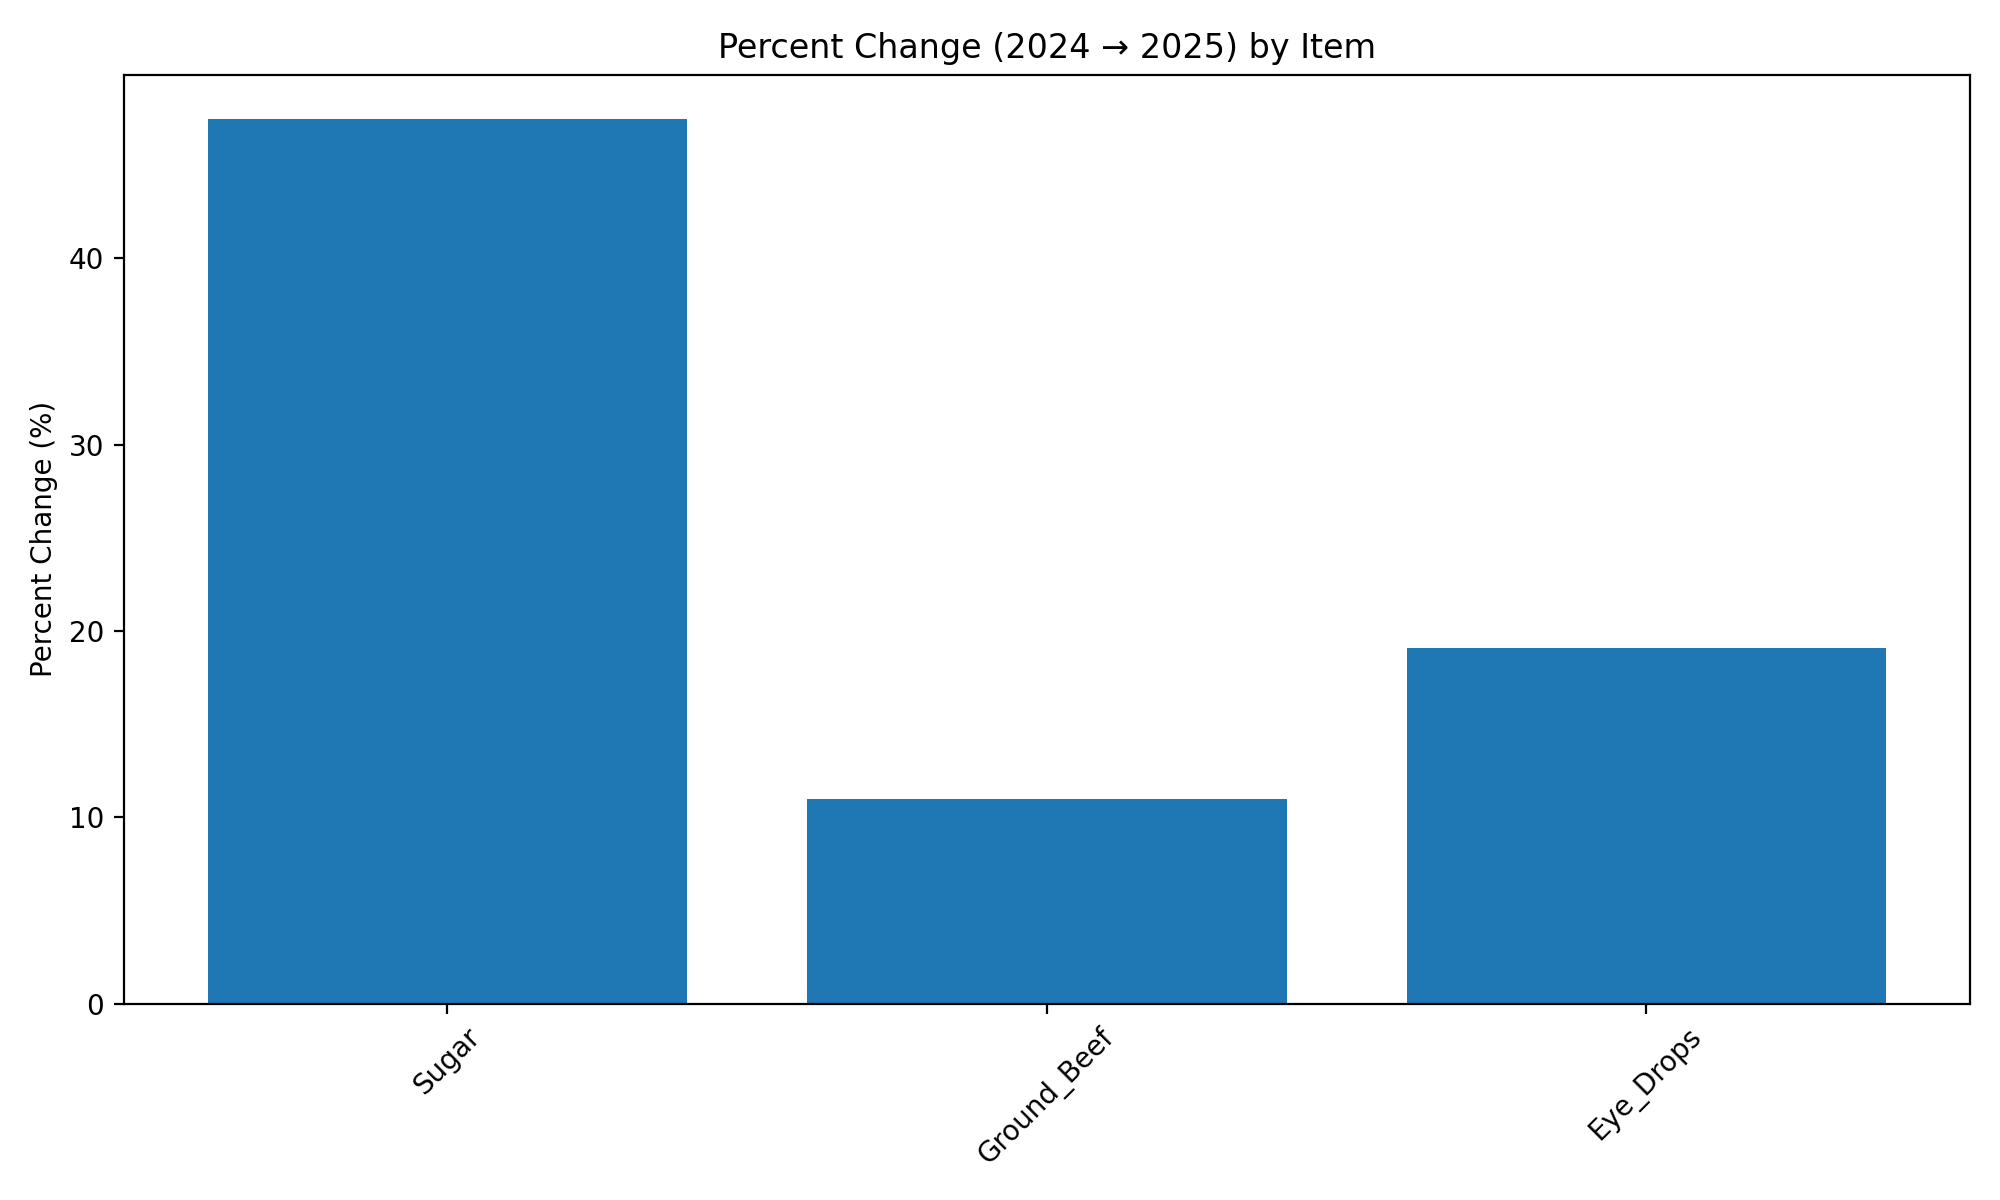

In [9]:
from IPython.display import Image, display

# Display the image in Python
image_path = "../The-Cost-of-Democracy/asmaa/plots/serpapi_percent_change_2024-2025.png"
display(Image(filename=image_path))

We can see that the cost of these items has risen since 2024.

# 2. How do those changes in price compare to the previous election cycle?

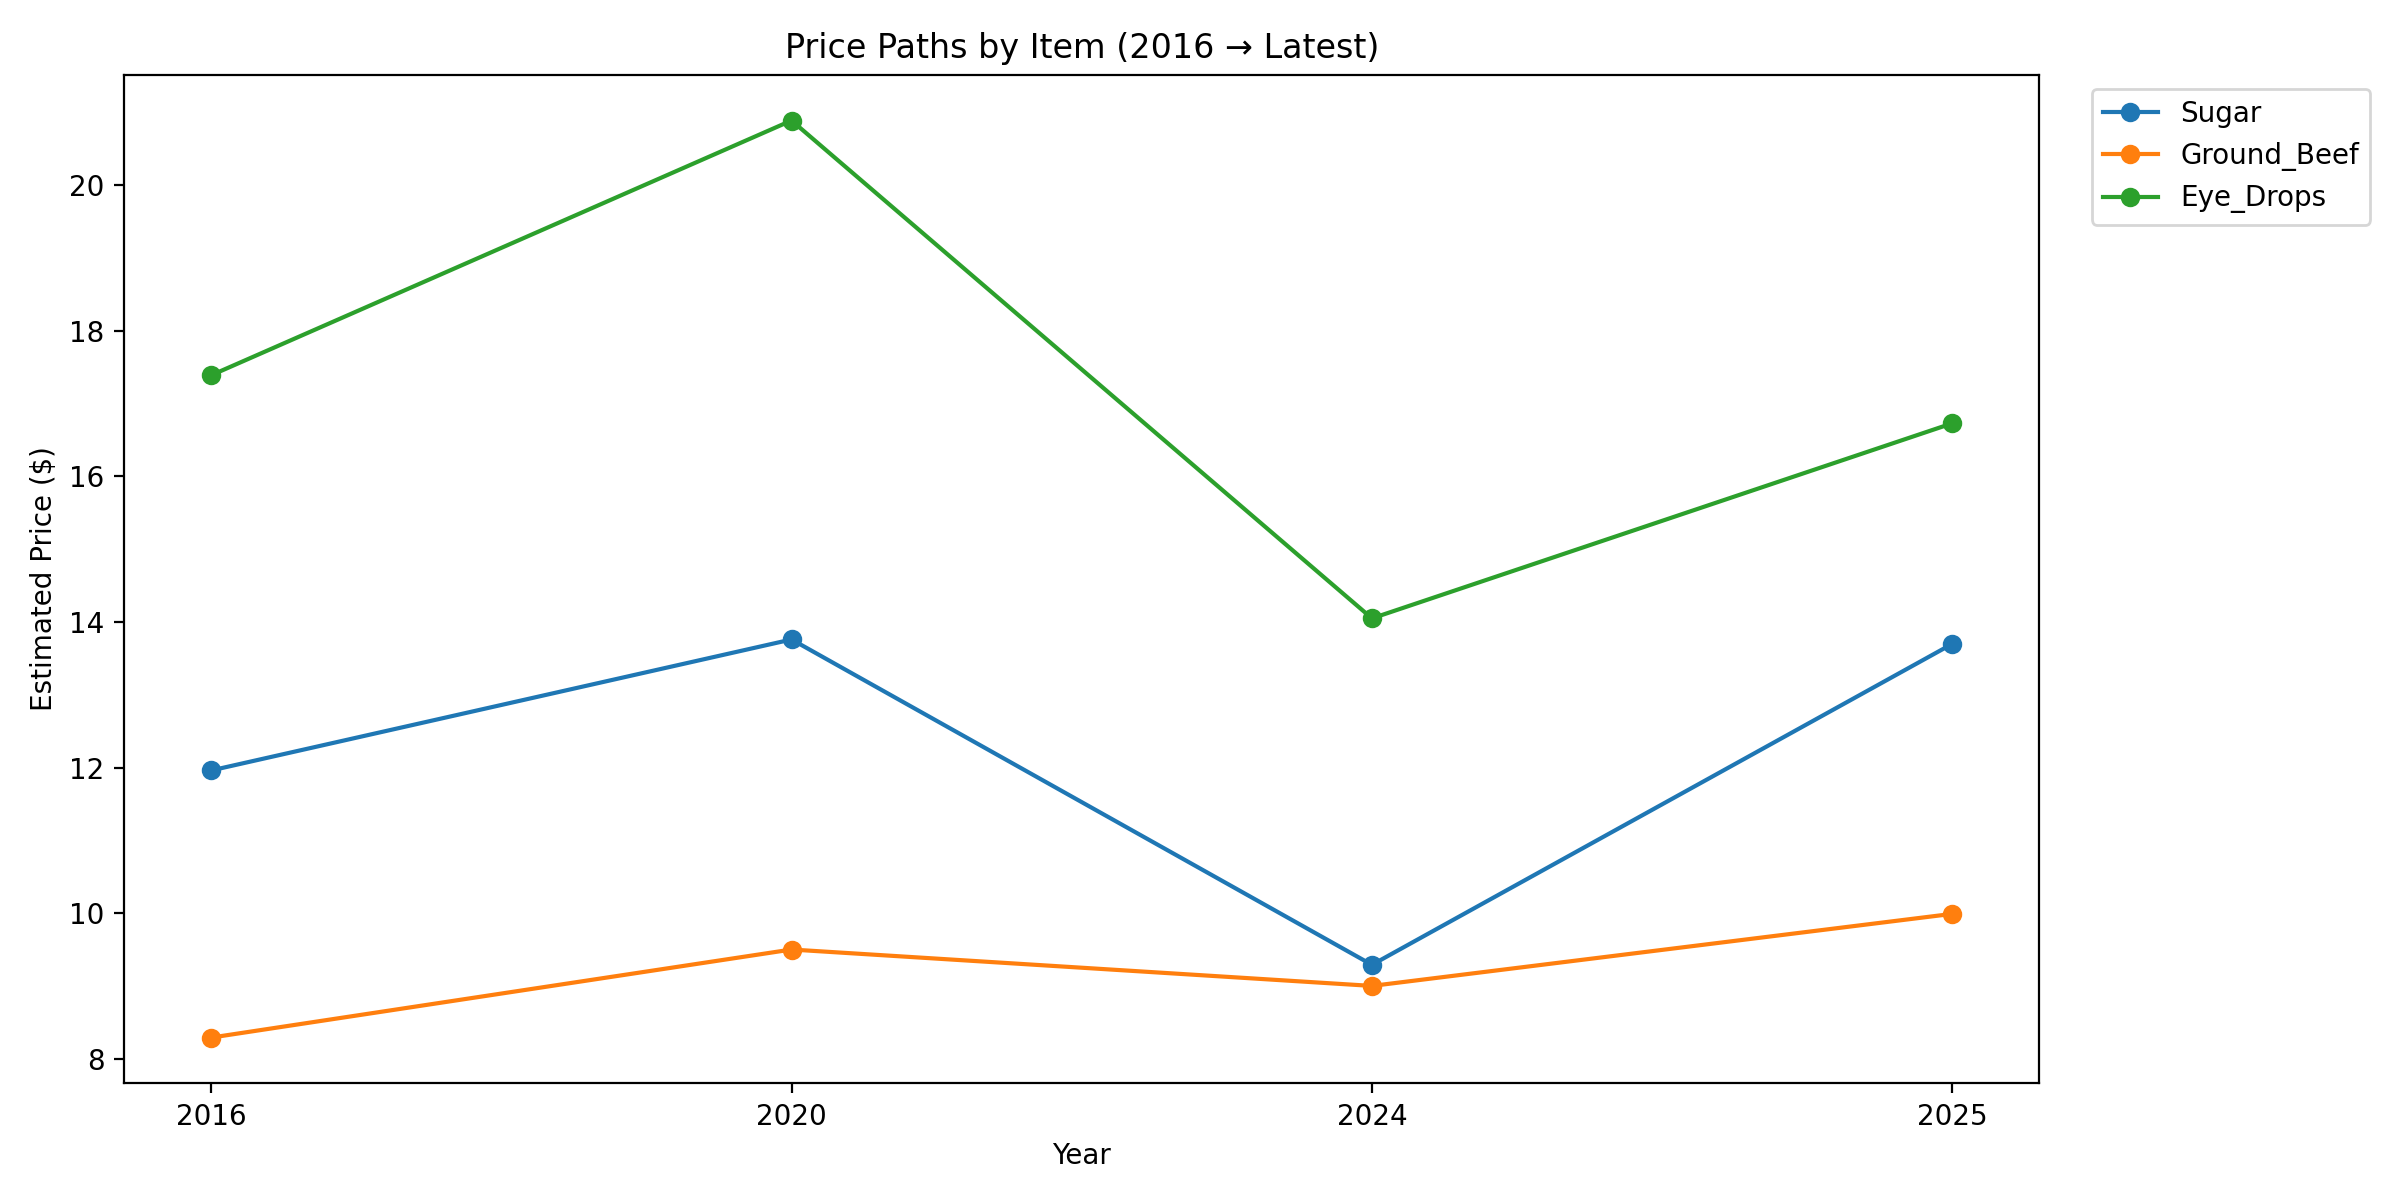

In [ ]:
# Display the image in Python
image_path = "../The-Cost-of-Democracy/asmaa/plots/serpapi_price_paths_since_2016.png"
display(Image(filename=image_path))

- We can see that prices rose during Trump's first term (2016-2020)
- Price then started to decline during the Biden administration (2020-2024)
- The data is also showing we are now back in an upward trend since the last election (2024-2025).

# 3. Was there ever an election cycle that had opposite effects?

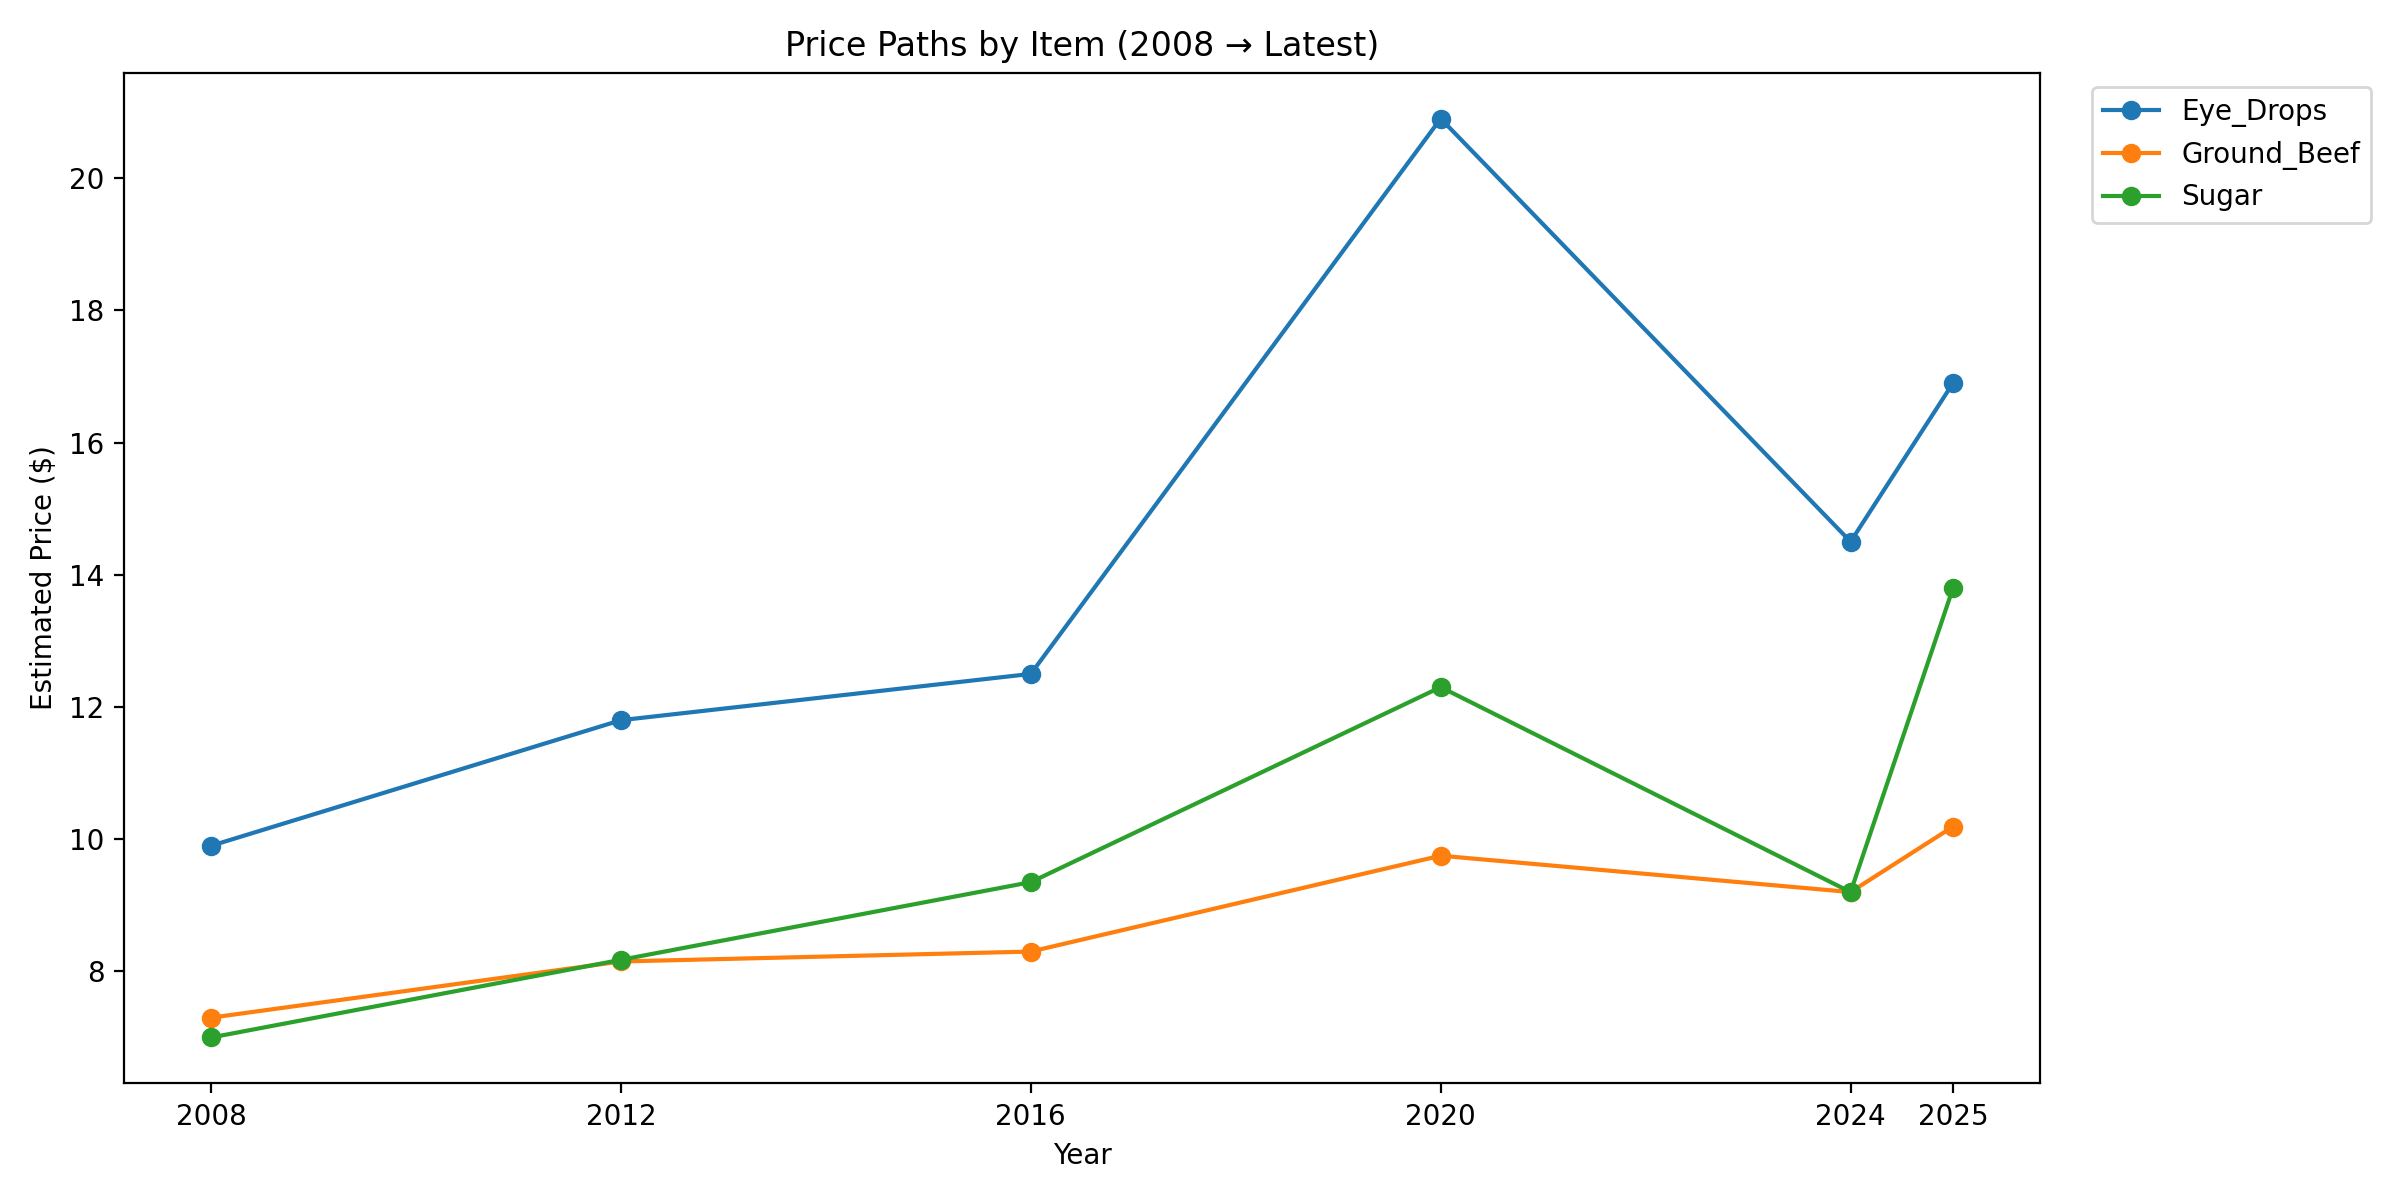

In [ ]:
from IPython.display import Image, display

# Display the image in Python
image_path = "../The-Cost-of-Democracy/asmaa/plots/serpapi_price_paths_since_2008.png"
display(Image(filename=image_path))

Yes — the 2020 → 2024 period shows an opposite effect compared to earlier cycles:

- Eye Drops and Sugar prices dropped sharply, reversing prior gains.

- Ground Beef prices dipped slightly after rising in previous terms.

This contrasts with earlier election cycles, where prices generally rose between each 4-year period.

## Conclusion

In conclusion, this analysis shows that political transitions can have measurable impacts on retail prices, with some election cycles driving declines and others triggering increases. Since the 2024 election, however, we’ve seen a clear and consistent upward trend across all products studied. These findings suggest that shifts in political leadership may correlate with changes in consumer prices, highlighting the value of ongoing monitoring to better understand and anticipate the economic effects of democratic transitions.